In [1]:
import numpy as np

metric_name = 'HttpDispatcher' # Throughput
period_millis = 60 * 1000
frequency_millis = 60 * period_millis
frequency_unit_label = 'hour'
sample_rate = float(frequency_millis) / float(period_millis)

In [2]:
import pandas as pd

data_frame = pd.read_csv('host-data.csv')
data_frame = data_frame.drop('date', 1).drop('max_swapUsedBytes', 1).tail(24 * 60)
call_counts = data_frame.values.transpose()[1]

offset = call_counts.mean()
call_counts_normal = call_counts - offset

In [3]:
# naive resynthesis from some set of the original fft
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

X = np.fft.fft(call_counts_normal)

plt.subplot(311)
plt.plot(call_counts, 'b')
plt.axis('tight')
plt.title(metric_name)

plt.subplot(312)
plt.plot(np.abs(X[:int(X.size / 2)]), 'r')
plt.axis('tight')
plt.title('Magnitude spectrum')

plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(9, 6))

removal_plot = plt.subplot(311)
removal_ifft_plot = plt.subplot(312)
half_ifft_plot = plt.subplot(313)

def animate_naive_resynthesis(i):
    compression_ratio = (i + 1) * 2
    removal_plot.cla()
    removal_ifft_plot.cla()
    half_ifft_plot.cla()
    removal_plot.set_title('Sampling every ' + str(compression_ratio) + ' points')
    removal_ifft_plot.set_title('Sampling every ' + str(compression_ratio) + ' DFT bins')
    half_ifft_plot.set_title('Using first 1/' + str(compression_ratio) + ' of DFT')
    removal_plot.plot(call_counts, 'g')
    removal_ifft_plot.plot(call_counts, 'g')
    half_ifft_plot.plot(call_counts, 'g')
    X_compressed = X.copy()
    # keep every nth element
    mask = np.ones(X.size, np.bool)
    mask[1::compression_ratio] = 0
    X_compressed[mask] = 0
    x = np.linspace(0, call_counts.size, call_counts.size / compression_ratio)
    removal_plot.plot(x, call_counts[::compression_ratio], 'b')
    removal_ifft_plot.plot(np.fft.ifft(X_compressed).real + offset, 'r')
    half_ifft_plot.plot(x, np.fft.ifft(X[:int(X.size / compression_ratio)]).real + offset, 'r')
    removal_ifft_plot.axis('tight')
    removal_plot.axis('tight')
    half_ifft_plot.axis('tight')
    plt.tight_layout()

anim = animation.FuncAnimation(fig, animate_naive_resynthesis, frames=6, repeat=False, interval=100)
HTML(anim.to_html5_video())

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


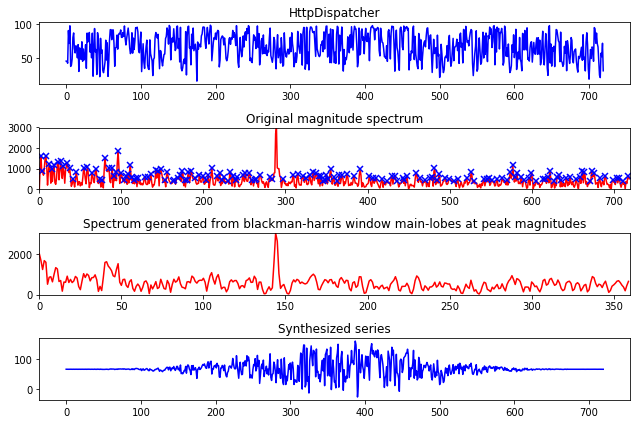

In [4]:
# reproduce from generated window main-lobe spectra using both windowed and non-windowed versions of the input series

# TODO calculate compression ratio of reproduction

from scipy import signal
from scipy.fftpack import fft, ifft, fftshift
import dft
M = int(call_counts.size)
N = int(call_counts.size * 2)
hN = int(N / 2)
Ns = int(N / 2)
hNs = int(Ns / 2)

w = np.blackman(M)
w /= np.sum(w)
mX_windowed, pX_windowed = dft.dft_model(call_counts_normal, N, w)
magnitude_threshold = np.max(mX_windowed) / 16
ip_loc_windowed, ip_mag_windowed, ip_phase_windowed = dft.interpolate_parabolic(mX_windowed, pX_windowed, dft.detect_peaks(mX_windowed, magnitude_threshold))
ip_freq_windowed = ip_loc_windowed * sample_rate / float(N)
Y_windowed = dft.gen_spec_sines(ip_freq_windowed, ip_mag_windowed, ip_phase_windowed, Ns, sample_rate)

mY_windowed = np.abs(Y_windowed[:hNs])
y_windowed = fftshift(ifft(Y_windowed)).real

mX, pX = dft.dft_model(call_counts_normal, N, None)
ip_loc, ip_mag, ip_phase = dft.interpolate_parabolic(mX, pX, dft.detect_peaks(mX, mX.max() / 8))
ip_freq = ip_loc * sample_rate / float(N)
Y = dft.gen_spec_sines(ip_freq, ip_mag, ip_phase, Ns, sample_rate)
mY = np.abs(Y[:hNs])
y = fftshift(ifft(Y)).real

plt.clf()
plt.figure(figsize=(9, 6))

plt.subplot(411)
plt.plot(call_counts, 'b')
plt.axis('tight')
plt.title(metric_name)

plt.subplot(412)
plt.plot(mX, 'r')
plt.plot(ip_loc, ip_mag, marker='x', color='b', linestyle='', markeredgewidth=1.5) 
plt.axis([0, hN, 0, max(mX) + 2])
plt.title('Original magnitude spectrum')

plt.subplot(413)
plt.plot(mY, 'r')
plt.axis([0, hNs, 0, max(mY) + 2])
plt.title('Spectrum generated from blackman-harris window main-lobes at peak magnitudes')

plt.subplot(414)
plt.plot(y + offset, 'b')
plt.axis('tight')
plt.title('Synthesized series')
plt.tight_layout()
plt.show()

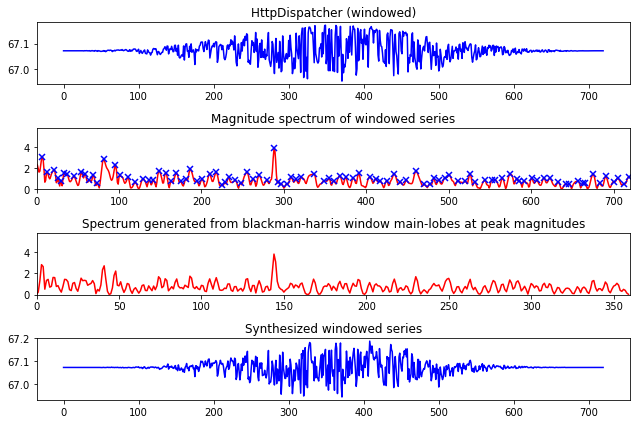

In [5]:
plt.figure(figsize=(9, 6))

plt.subplot(411)
plt.plot(call_counts_normal * w + offset, 'b')
plt.axis('tight')
plt.title(str(metric_name) + ' (windowed)')

plt.subplot(412)
plt.plot(mX_windowed, 'r')
plt.plot(ip_loc_windowed, ip_mag_windowed, marker='x', color='b', linestyle='', markeredgewidth=1.5) 
plt.axis([0, hN, 0, max(mX_windowed) + 2])
plt.title('Magnitude spectrum of windowed series')

plt.subplot(413)
plt.plot(mY_windowed, 'r')
plt.axis([0, hNs, 0, max(mY_windowed) + 2])
plt.title('Spectrum generated from blackman-harris window main-lobes at peak magnitudes')

plt.subplot(414)
plt.plot(y_windowed + offset, 'b')
plt.axis('tight')
plt.title('Synthesized windowed series')
plt.tight_layout()
plt.show()